### Business background 

- Many everyday investors hold or follow large, well-known U.S. stocks such as Tesla (TSLA), JPMorgan (JPM), Microsoft (MSFT), Apple (AAPL), and ExxonMobil (XOM). A common question among investors is often whether simple patterns in recent price movements can tell them anything about short-term behavior, such as whether a stock is likely to move up or down over the next week or whether the stock is currently in a “calmer” or “more volatile” period. 

- Our project explores this question using only basic daily price data. We study five large stocks plus the S&P 500 index fund (SPY) and ask: 

Can we use simple statistics based on daily returns to help us (1) group days into different market “modes” and (2) build machine learning models that predict next week's movement and returns? 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>feature</th>
      <th>type</th>
      <th>description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>daily_return</td>
      <td>float</td>
      <td>1-day percent return of the stock (current clo...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>mean_5d</td>
      <td>float</td>
      <td>Rolling 5-day average of the stock's daily ret...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>vol_5d</td>
      <td>float</td>
      <td>Rolling 5-day standard deviation of the stock'...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>spy_return</td>
      <td>float</td>
      <td>1-day percent return of SPY (market proxy) on ...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ret_5d_fwd</td>
      <td>float (target)</td>
      <td>Forward 5-day return of the stock (regression ...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>up_5d</td>
      <td>int (0/1 target)</td>
      <td>Classification label: 1 if ret_5d_fwd &gt; 0, els...</td>
    </tr>
  </tbody>
</table>
</div>

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score

import yfinance as yf


### Gathering Data 


In [2]:
tickers = ["TSLA", "JPM", "MSFT", "AAPL", "XOM"]
benchmark = "SPY"

start_date = "2015-01-01"
end_date = None

raw_data = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

raw_data.head()

Price           Close                                                   High  \
Ticker           AAPL        JPM       MSFT       TSLA        XOM       AAPL   
Date                                                                           
2015-01-02  24.237549  46.720928  39.858463  14.620667  57.916912  24.705318   
2015-01-05  23.554741  45.270473  39.491909  14.006000  56.332195  24.086801   
2015-01-06  23.556957  44.096661  38.912281  14.085333  56.032722  23.816336   
2015-01-07  23.887280  44.163960  39.406681  14.063333  56.600483  23.987040   
2015-01-08  24.805079  45.150860  40.565956  14.041333  57.542568  24.862719   

Price                                                   ...       Open  \
Ticker            JPM       MSFT       TSLA        XOM  ...       AAPL   
Date                                                    ...              
2015-01-02  47.072324  40.421051  14.883333  58.054171  ...  24.694233   
2015-01-05  46.563915  39.832869  14.433333  57.648631  ...  24.006992   
2015-01-06  45.420009  39.849925  14.280000  57.030971  ...  23.619031   
2015-01-07  44.777036  39.602734  14.318667  57.074651  ...  23.765348   
2015-01-08  45.532165  40.702341  14.253333  57.567520  ...  24.215380   

Price                                                      Volume            \
Ticker            JPM       MSFT       TSLA        XOM       AAPL       JPM   
Date                                                                          
2015-01-02  46.489154  39.773224  14.858000  57.555047  212818400  12600000   
2015-01-05  46.399433  39.526003  14.303333  57.461458  257142000  20100600   
2015-01-06  45.337767  39.534536  14.004000  56.301001  263188400  29074100   
2015-01-07  44.777036  39.193580  14.223333  56.556810  160423600  23843200   
2015-01-08  44.836846  39.849936  14.187333  56.931141  237458000  16971100   

Price                                     
Ticker          MSFT      TSLA       XOM  
Date                                      
2015-01-02  27913900  71466000  10220400  
2015-01-05  39673900  80527500  18502400  
2015-01-06  36447900  93928500  16670700  
2015-01-07  29114100  44526000  13590700  
2015-01-08  29645200  51637500  15487500  

[5 rows x 25 columns]

In [3]:
prices_stocks = raw_data["Close"].copy()
display(prices_stocks.head())

Ticker,AAPL,JPM,MSFT,TSLA,XOM
Date,,,,,
2015-01-02,24.237549,46.720928,39.858463,14.620667,57.916912
2015-01-05,23.554741,45.270473,39.491909,14.006000,56.332195
2015-01-06,23.556957,44.096661,38.912281,14.085333,56.032722
2015-01-07,23.887280,44.163960,39.406681,14.063333,56.600483
2015-01-08,24.805079,45.150860,40.565956,14.041333,57.542568


In [4]:
spy_close = yf.download(
    benchmark,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]
display(spy_close.head())

Ticker,SPY
Date,
2015-01-02,171.093658
2015-01-05,168.003784
2015-01-06,166.421356
2015-01-07,168.495209
2015-01-08,171.485138


In [5]:
prices = pd.concat([prices_stocks, spy_close], axis=1)
prices = prices.dropna(how="any")
prices

Ticker,AAPL,JPM,MSFT,TSLA,XOM,SPY
Date,,,,,,
2015-01-02,24.237549,46.720928,39.858463,14.620667,57.916912,171.093658
2015-01-05,23.554741,45.270473,39.491909,14.006000,56.332195,168.003784
2015-01-06,23.556957,44.096661,38.912281,14.085333,56.032722,166.421356
2015-01-07,23.887280,44.163960,39.406681,14.063333,56.600483,168.495209
2015-01-08,24.805079,45.150860,40.565956,14.041333,57.542568,171.485138
...,...,...,...,...,...,...
2025-11-26,277.549988,307.640015,485.500000,426.579987,114.769997,679.679993
2025-11-28,278.850006,313.079987,492.010010,430.170013,115.919998,683.390015
2025-12-01,283.100006,308.920013,486.739990,430.140015,116.629997,680.270020


### Data Understanding

In [6]:
print(f"Combined prices shape: {prices.shape}")
print(f"Combined Columns: {prices.columns.tolist()}")

Combined prices shape: (2747, 6)
Combined Columns: ['AAPL', 'JPM', 'MSFT', 'TSLA', 'XOM', 'SPY']


In [7]:
print("Prices info:")
print(prices.info())
print("="*50)
print("Summary statistics for closing prices:")
display(prices.describe().T)

Prices info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2747 entries, 2015-01-02 to 2025-12-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2747 non-null   float64
 1   JPM     2747 non-null   float64
 2   MSFT    2747 non-null   float64
 3   TSLA    2747 non-null   float64
 4   XOM     2747 non-null   float64
 5   SPY     2747 non-null   float64
dtypes: float64(6)
memory usage: 150.2 KB
None
Summary statistics for closing prices:


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2747.0,105.157884,73.236218,20.604076,36.528530,85.296890,167.840843,286.190002
JPM,2747.0,118.526341,64.272066,40.657459,74.760105,98.691017,140.523178,320.410004
MSFT,2747.0,204.257082,141.911974,34.437168,68.383049,186.314865,307.761597,541.057373
TSLA,2747.0,135.218365,128.310250,9.578000,17.796000,65.732002,239.723335,479.859985
XOM,2747.0,68.501205,25.101353,24.145132,52.548077,57.134533,96.088242,119.946037
SPY,2747.0,336.537829,138.660603,155.438797,219.407181,300.186981,423.217514,687.390015


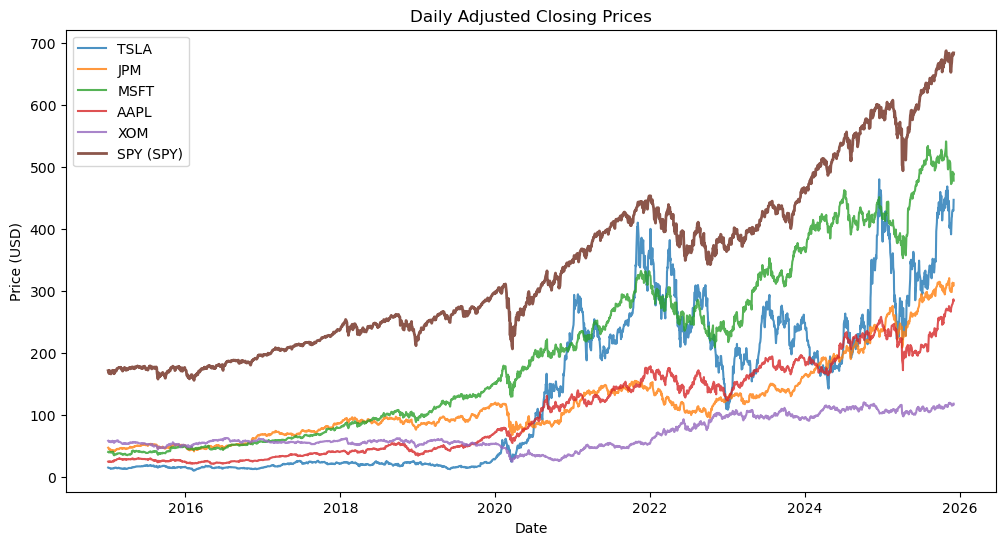

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
for t in tickers:
    ax.plot(prices.index, prices[t], label=t, alpha=0.8)

ax.plot(prices.index, prices[benchmark], label=benchmark + " (SPY)", linewidth=2)
ax.set_title("Daily Adjusted Closing Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()

In [9]:
# daily returns
returns = prices.pct_change().dropna()
print(f"Returns shape: {returns.shape}")

print("="*50)

print("Summary statistics for daily returns:")
display(returns.describe().T)

Returns shape: (2746, 6)
Summary statistics for daily returns:


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2746.0,0.001063,0.018225,-0.128647,-0.007301,0.000994,0.010069,0.153289
JPM,2746.0,0.000838,0.017108,-0.149649,-0.007031,0.000692,0.008922,0.180125
MSFT,2746.0,0.001049,0.016978,-0.147391,-0.006727,0.000954,0.009439,0.142169
TSLA,2746.0,0.001907,0.036454,-0.210628,-0.016545,0.001260,0.019595,0.226900
XOM,2746.0,0.000408,0.017305,-0.122248,-0.008204,0.000276,0.008993,0.126868
SPY,2746.0,0.000568,0.011237,-0.109424,-0.003707,0.000645,0.005929,0.105019


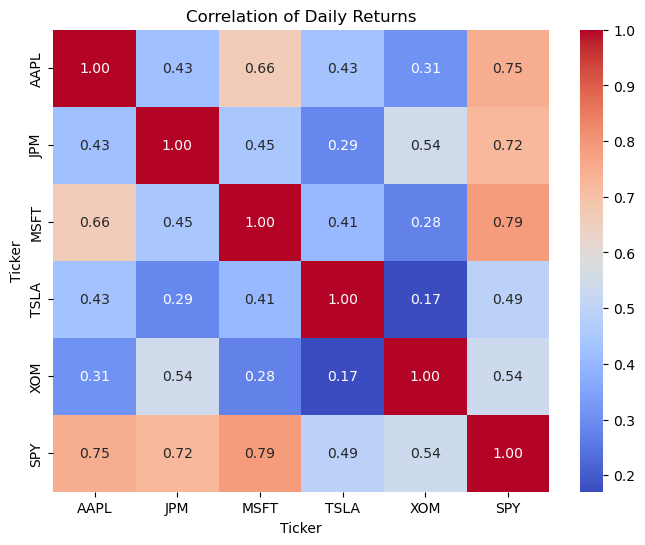

In [10]:
# correlation of returns
corr = returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Daily Returns")
plt.show()

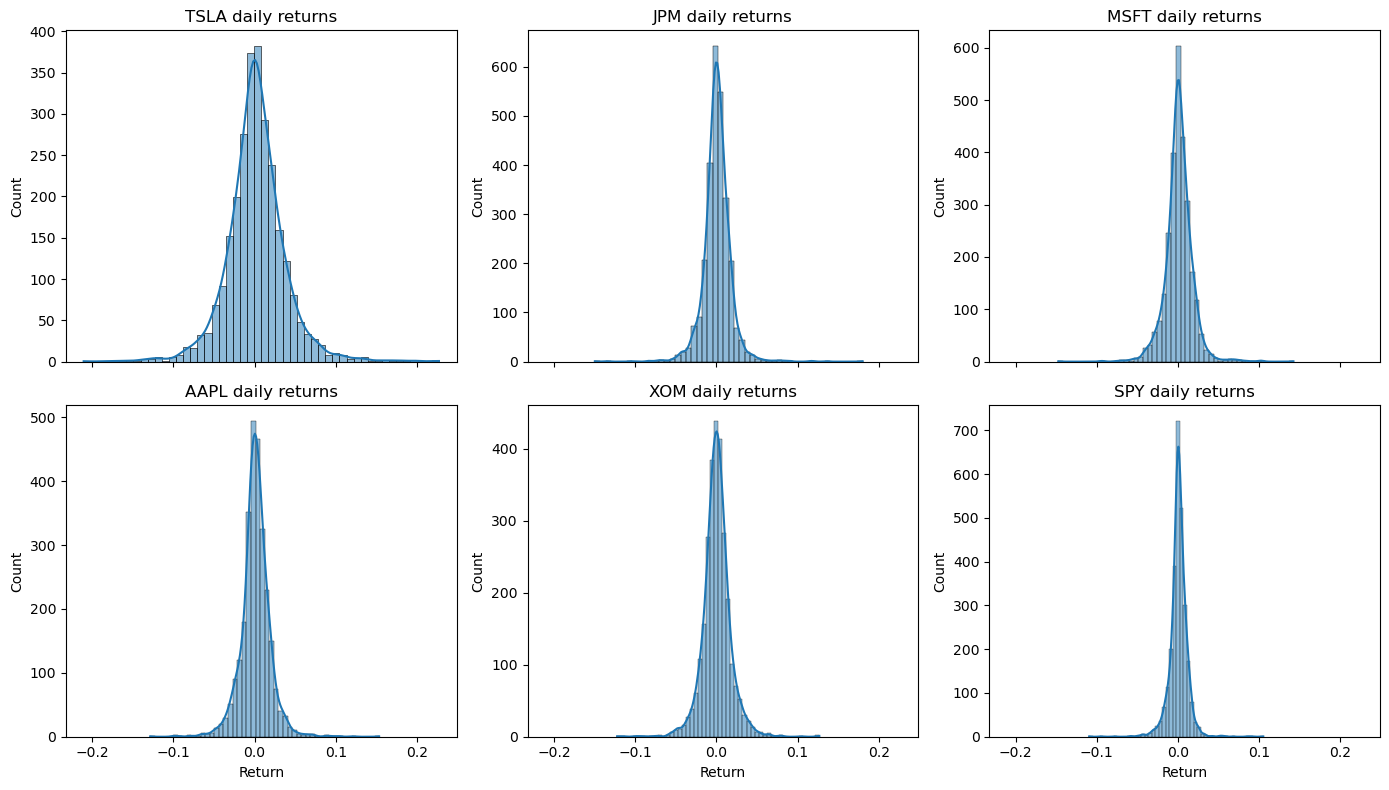

In [11]:
# hostogram of returns
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)
axes = axes.flatten()
all_tickers = tickers + [benchmark]

for i, t in enumerate(all_tickers):
    sns.histplot(returns[t], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{t} daily returns")
    axes[i].set_xlabel("Return")

for j in range(len(all_tickers), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Feature Engineering & Targets

In [12]:
df = prices.stack().reset_index()
df.columns = ["date", "ticker", "price"]
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

df["daily_return"] = df.groupby("ticker")["price"].pct_change()

# adding spy return
spy = df[df["ticker"] == benchmark][["date", "daily_return"]].rename(
    columns={"daily_return": "spy_return"}
)

stocks = df[df["ticker"].isin(tickers)].copy()
stocks = stocks.merge(spy, on="date", how="left")
stocks

,date,ticker,price,daily_return,spy_return
0,2015-01-02,AAPL,24.237549,NaN,NaN
1,2015-01-05,AAPL,23.554741,-0.028171,-0.018060
2,2015-01-06,AAPL,23.556957,0.000094,-0.009419
3,2015-01-07,AAPL,23.887280,0.014022,0.012461
4,2015-01-08,AAPL,24.805079,0.038422,0.017745
...,...,...,...,...,...
13730,2025-11-26,XOM,114.769997,0.002270,0.006903
13731,2025-11-28,XOM,115.919998,0.010020,0.005458
13732,2025-12-01,XOM,116.629997,0.006125,-0.004565
13733,2025-12-02,XOM,115.379997,-0.010718,0.001852


In [13]:
# Adding features:

# rolling 5 day mean and volatily of the returns for each ticker

stocks["mean_5d"] = (
    stocks.groupby("ticker")["daily_return"]
          .rolling(window=5, min_periods=5)
          .mean()
          .reset_index(level=0, drop=True)
)

stocks["vol_5d"] = (
    stocks.groupby("ticker")["daily_return"]
          .rolling(window=5, min_periods=5)
          .std()
          .reset_index(level=0, drop=True)
)
stocks

,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d
0,2015-01-02,AAPL,24.237549,NaN,NaN,NaN,NaN
1,2015-01-05,AAPL,23.554741,-0.028171,-0.018060,NaN,NaN
2,2015-01-06,AAPL,23.556957,0.000094,-0.009419,NaN,NaN
3,2015-01-07,AAPL,23.887280,0.014022,0.012461,NaN,NaN
4,2015-01-08,AAPL,24.805079,0.038422,0.017745,NaN,NaN
...,...,...,...,...,...,...,...
13730,2025-11-26,XOM,114.769997,0.002270,0.006903,-0.004420,0.006404
13731,2025-11-28,XOM,115.919998,0.010020,0.005458,-0.001853,0.009179
13732,2025-12-01,XOM,116.629997,0.006125,-0.004565,-0.000731,0.009859
13733,2025-12-02,XOM,115.379997,-0.010718,0.001852,-0.000978,0.010145


In [14]:
# adding forward 5-day return and classification label
stocks["price_5d_fwd"] = stocks.groupby("ticker")["price"].shift(-5)
stocks["ret_5d_fwd"] = stocks["price_5d_fwd"] / stocks["price"] - 1
stocks["up_5d"] = (stocks["ret_5d_fwd"] > 0).astype(int)

display(stocks.head())

,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d,price_5d_fwd,ret_5d_fwd,up_5d
0,2015-01-02,AAPL,24.237549,NaN,NaN,NaN,NaN,24.831688,0.024513,1
1,2015-01-05,AAPL,23.554741,-0.028171,-0.018060,NaN,NaN,24.219814,0.028235,1
2,2015-01-06,AAPL,23.556957,0.000094,-0.009419,NaN,NaN,24.434856,0.037267,1
3,2015-01-07,AAPL,23.887280,0.014022,0.012461,NaN,NaN,24.341742,0.019025,1
4,2015-01-08,AAPL,24.805079,0.038422,0.017745,NaN,NaN,23.681107,-0.045312,0


In [ ]:
# creating final modeling dataset
feature_cols = ["daily_return", "mean_5d", "vol_5d", "spy_return"]
target_reg = "ret_5d_fwd"
target_clf = "up_5d"

model_df = stocks.dropna(subset=feature_cols + [target_reg, target_clf]).copy()
model_df = model_df.sort_values("date").reset_index(drop=True)

model_df.head()


,date,ticker,price,daily_return,spy_return,mean_5d,vol_5d,price_5d_fwd,ret_5d_fwd,up_5d
0,2015-01-09,AAPL,24.831688,0.001073,-0.008014,0.005088,0.024178,23.497107,-0.053745,0
1,2015-01-09,MSFT,40.224995,-0.008405,-0.008014,0.001969,0.018561,39.415203,-0.020132,0
2,2015-01-09,TSLA,13.777333,-0.018802,-0.008014,-0.011661,0.019223,12.871333,-0.065760,0
3,2015-01-09,XOM,57.461464,-0.001409,-0.008014,-0.001462,0.016941,56.850033,-0.010641,0
4,2015-01-09,JPM,44.365829,-0.017387,-0.008014,-0.010098,0.021967,41.816311,-0.057466,0


###  Unsupervised Learning - K-Means Clustering


### Supervised Learning - Train/Test Split

### Classification Model: Predict Up/Down in 5 Days

### Regression Model: Predict 5-Day Forward Return